In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, types
from numba.typed import Dict, List
import awkward as ak

In [4]:
#Lets try loading in the hit-wise reco:
data = np.load('../hitwise_detector_sim_0002459.npz')
neutrino_vertices = data['first']
hit_array = data['second']
np.shape(neutrino_vertices)
np.shape(hit_array)

(252256, 7)

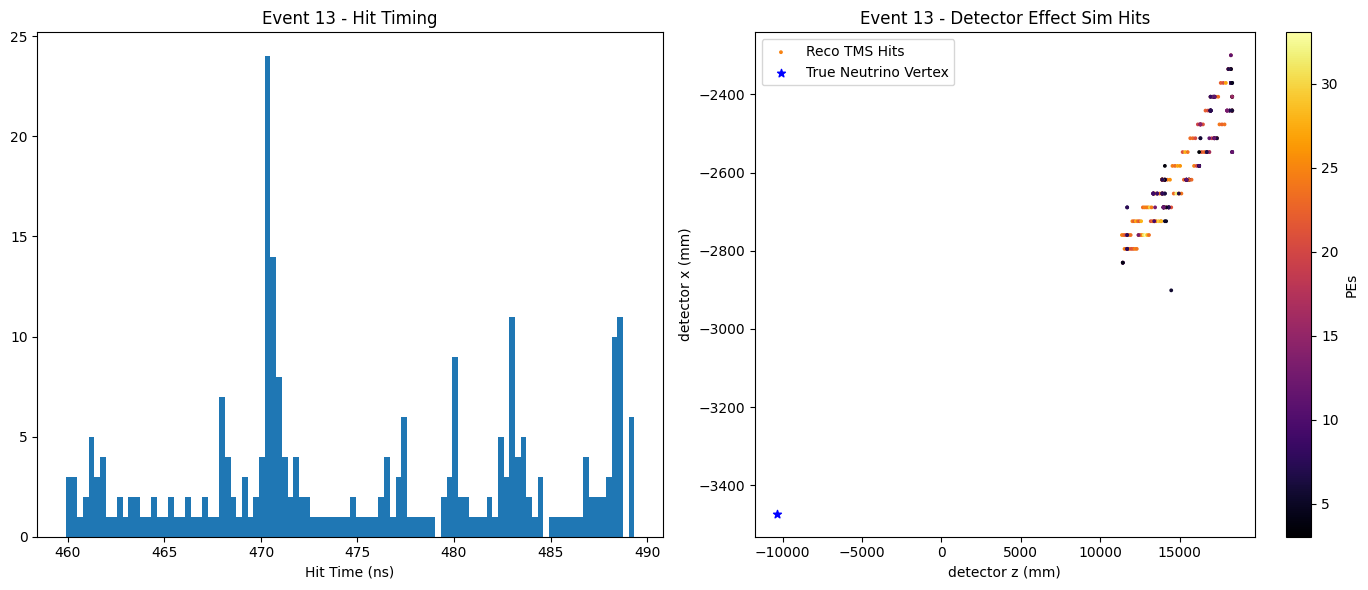

In [5]:
#Let's try and replicate some plots, to show successful data transfer - looks ok!

event_number_example = 13

# Reco hit data
reco_hit_xs = []
reco_hit_zs = []
reco_hit_PEs = []
reco_hit_Ts = []

for hit in hit_array:
    if (hit[0] == event_number_example):
        reco_hit_xs.append(hit[2])
        reco_hit_zs.append(hit[4])
        reco_hit_Ts.append(hit[5])
        reco_hit_PEs.append(hit[6])

event_neutrino = [vtx for vtx in neutrino_vertices if vtx[0] == event_number_example]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot reco hits
sc2 = ax2.scatter(reco_hit_zs, reco_hit_xs, s=3, c=reco_hit_PEs, cmap='inferno', label='Reco TMS Hits')
ax2.scatter(event_neutrino[0][3], event_neutrino[0][1], s=35, c='blue', marker='*', label='True Neutrino Vertex')
ax2.set_xlabel("detector z (mm)")
ax2.set_ylabel("detector x (mm)")
ax2.set_title(f"Event {event_number_example} - Detector Effect Sim Hits")
ax2.legend()
fig.colorbar(sc2, ax=ax2, label='PEs')

# Plot truth hits
sc1 = ax1.hist(reco_hit_Ts, bins=100)
ax1.set_xlabel("Hit Time (ns)")
ax1.set_title(f"Event {event_number_example} - Hit Timing")

plt.tight_layout()
plt.show()


In [6]:
#Great so we seem to have preserved all of our information - lets try some processing now, and we can hopefully use numba to make it faster. 

In [7]:
#A largely chat-gpt inspired function that creates a dictionary keyed by unique (x,z) hold the indices of the hit_array with that key
#Note, this uses some Numba classes, so if we remove return statements this could be run super fast with @jit. It works just fine now though.
def sort_by_bar(hit_array):
    N = hit_array.shape[0]

    # Group hits by (x, z)
    group_dict = Dict.empty(
        key_type=types.UniTuple(types.float64, 2),
        value_type=types.ListType(types.int64)
    )

    for i in range(N):
        x = hit_array[i, 2]
        z = hit_array[i, 4]
        key = (x, z)
        if key not in group_dict:
            group_dict[key] = List.empty_list(types.int64)
        group_dict[key].append(i)
        
    return(group_dict)


In [8]:
bar_dictionary = sort_by_bar(hit_array)

In [9]:
#single key test. 
index_list = bar_dictionary[(236.0794828823772, 11588.0)]
readout_window = 120
times = [hit_array[i][5] for i in index_list]
sorted_idx = np.argsort(times) #returns indixes that would sort a list. - not matched to hits
sorted_times = [times[i] for i in sorted_idx] #times sorted by times
sorted_indices = [index_list[i] for i in sorted_idx] #return sorted list of hit indices
time_index_array = np.column_stack((sorted_times, sorted_indices))

groups = []
current_group = [int(time_index_array[0][1])]
t_start = time_index_array[0][0]

for i in range(1, time_index_array.shape[0]):
    t = time_index_array[i][0]
    idx = int(time_index_array[i][1])

    if t - t_start <= readout_window: #check if it falls into the current group
        current_group.append(idx)
    else:
        groups.append(current_group) #if not, create new group and reset the starting time!
        current_group = [idx]
        t_start = t

# Add the final group
if current_group: #need to close the last group. 
    groups.append(current_group)

# Print result
for i, group in enumerate(groups):
    print(f"Group {i}: {group}")


Group 0: [9]
Group 1: [45182, 45181, 45214]
Group 2: [79361]
Group 3: [159404]
Group 4: [170689]
Group 5: [189133, 189134, 189135, 189136, 189137]
Group 6: [225126, 225125]


In [24]:
#full group sorting. Make into a function that just takes args readout window and bar_dictionary returns all_groups
#%%time
all_groups = []
for key in bar_dictionary:
    readout_window = 120
    index_list = bar_dictionary[key]
    #total_objects += len(index_list)
    times = [hit_array[i][5] for i in index_list]
    sorted_idx = np.argsort(times) #returns indixes that would sort a list. - not matched to hits
    sorted_times = [times[i] for i in sorted_idx] #times sorted by times
    sorted_indices = [index_list[i] for i in sorted_idx] #return sorted list of hit indices
    start = 0
    time_index_array = np.column_stack((sorted_times, sorted_indices)) #perhaps a useful object
    groups = []
    current_group = [int(time_index_array[0][1])]
    t_start = time_index_array[0][0]

    for i in range(1, time_index_array.shape[0]):
        t = time_index_array[i][0]
        idx = int(time_index_array[i][1])

        if t - t_start <= readout_window:
            current_group.append(idx)
        else:
            groups.append(current_group)
            current_group = [idx]
            t_start = t

    # Add the final group
    if current_group:
        groups.append(current_group)

    # Print result
    for i, group in enumerate(groups):
        print(f"Key {key} - Group {i}: {group}")

        all_groups.append(group)

   
            
   

Key (-1120.3659359075525, 11588.0) - Group 0: [0]
Key (-1120.3659359075525, 11588.0) - Group 1: [184433, 184432, 184501]
Key (-1120.3659359075525, 11588.0) - Group 2: [210991, 211034, 210993, 210992, 211035, 211036]
Key (-1084.9944777865455, 11588.0) - Group 0: [1, 4, 2, 3]
Key (-1084.9944777865455, 11588.0) - Group 1: [55432, 55574, 55594, 55593, 55576, 55595, 55575]
Key (-1084.9944777865455, 11588.0) - Group 2: [69885, 69892, 69886]
Key (-1084.9944777865455, 11588.0) - Group 3: [107403, 107208]
Key (-1084.9944777865455, 11588.0) - Group 4: [162188]
Key (-1084.9944777865455, 11588.0) - Group 5: [206467, 206466]
Key (-1084.9944777865455, 11588.0) - Group 6: [210990, 210988, 210989]
Key (200.70802476137032, 11368.0) - Group 0: [5]
Key (200.70802476137032, 11368.0) - Group 1: [45175]
Key (200.70802476137032, 11368.0) - Group 2: [58620]
Key (200.70802476137032, 11368.0) - Group 3: [68495, 68496]
Key (200.70802476137032, 11368.0) - Group 4: [127889, 127890, 127888, 127891, 127892, 127893, 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Key (-2264.5826059714404, 16153.0) - Group 0: [32065]
Key (-2264.5826059714404, 16153.0) - Group 1: [154048]
Key (-2264.5826059714404, 16153.0) - Group 2: [232438]
Key (-2264.5826059714404, 16153.0) - Group 3: [243803, 243802, 244102, 243966, 243827, 244183, 244376, 244240, 243833, 243784, 243829, 244172, 244293, 243651, 244459, 243891, 244371, 244275, 244370, 243964, 244413, 244355, 244369, 243626, 244309, 243765, 243654, 243965, 244414, 243527, 244311, 244031, 244368, 244310, 243524, 244156, 243698, 243635, 244028, 244139, 244301, 244192, 244415, 244342, 244029, 244300, 243622, 244096, 244193, 243970, 244218, 244164, 244199, 244135, 243794, 243874, 244267, 244262, 244141, 244343, 244090, 244346, 244314, 244284, 244302, 244257, 243785, 243605, 243861, 244431, 244030, 244143, 244136, 243687, 244259, 243899, 243957, 243616, 243608, 243873, 243968, 243554, 244243, 243555, 243683, 244356, 244272, 243685, 243894, 244273, 243609, 244150, 244358, 244205, 244274, 243501, 244185, 244184, 24420

In [22]:
#single group test merge
#this is a physics question but I think in the event there are multiple neutrino events represented in a grouped hit the neutrino number associated with the 
#largest PE hit should be the neutrino number and hit number assigned to the collected hit. 
hit_indexes = all_groups[6]
total_PE = 0.
collective_neutrino_number = -1
collective_hit_number = -1
neutrino_numbers = []
hit_numbers = []
hit_pes = []
hit_times = []

bar_x = hit_array[hit_indexes[0]][2] 
bar_y = hit_array[hit_indexes[0]][3] 
bar_z = hit_array[hit_indexes[0]][4] 

for index in hit_indexes:
    print(hit_array[index])

for index in hit_indexes:
    hit = hit_array[index]
    hit_times.append(hit[5])
    neutrino_numbers.append(hit[0])
    hit_numbers.append(hit[1])
    hit_pes.append(hit[6])
    

if (len(np.unique(neutrino_numbers)) > 1):
    print("Notice - multiple neutrino numbers in this group, will merge to earliest time")

min_time_index = np.argmin(hit_times)
print(min_time_index)
total_pe = sum(hit_pes)
collective_neutrino_number = neutrino_numbers[min_time_index]
collective_hit_number = hit_numbers[min_time_index]
collective_index = hit_indexes[min_time_index]
collective_time = hit_times[min_time_index]
print(hit_indexes)
merged_hit_info = [collective_neutrino_number, collective_hit_number, bar_x, bar_y, bar_z, collective_time, total_pe, hit_indexes]
print(merged_hit_info)

[ 2.56100000e+03  2.38000000e+02 -1.08499448e+03 -9.99990000e+07
  1.15880000e+04  6.00000601e+09  1.21917658e+01]
[ 2.56100000e+03  9.00000000e+00 -1.08499448e+03 -9.99990000e+07
  1.15880000e+04  6.00000601e+09  2.50582008e+01]
0
[107403, 107208]
[np.float64(2561.0), np.float64(238.0), np.float64(-1084.9944777865455), np.float64(-99999000.0), np.float64(11588.0), np.float64(6000006007.882652), np.float64(37.24996661695073), [107403, 107208]]


In [66]:
#Quick check on if this whole coincident hit merging thing actually matters that much at all in terms of collapsing multiple neutrino numbers
uniques = []
mvtx_counts = [] #returns counts for multiple vertices
for i in range(len(all_groups)):
    group = all_groups[i]
    nns = []
    for hit_index in group:
        hit = hit_array[hit_index]
        nns.append(hit[0])

    unique_values, counts = np.unique(nns, return_counts=True)
    uniques.append(len(unique_values))
    if (len(unique_values) > 1):
        mvtx_counts.append(counts)
        
print(len(uniques))
print(len(mvtx_counts))


107479
550


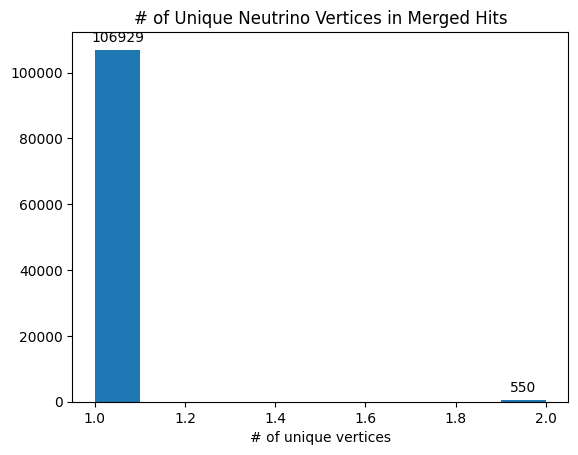

In [63]:
counts, bins, patches, = plt.hist(uniques)
plt.title("# of Unique Neutrino Vertices in Merged Hits")
plt.xlabel("# of unique vertices")
for patch in patches:
    # Get the height of the bar (frequency count)
    height = patch.get_height()
    if (height != 0) :
        # Get the x-coordinate of the center of the bar
        x_center = patch.get_x() + patch.get_width() / 2
    
        # Annotate the bar with its height
        plt.annotate(
            f'{int(height)}',  # The text to display (integer height)
            xy=(x_center, height-700),  # The point to annotate (center top of bar)
            xytext=(0, 5),  # Offset text slightly above the bar
            textcoords="offset points",
            ha='center',  # Horizontal alignment: center the text
            va='bottom'   # Vertical alignment: align text to the bottom of the offset
        )
plt.show()

In [18]:
#now for all groups!
merged_hit_collection = []
multi_neutrino_groups = 0
distinct_vertices_list = []
for i in range(len(all_groups)):
    hit_indexes = all_groups[i]
    total_PE = 0.
    collective_neutrino_number = -1
    collective_hit_number = -1
    neutrino_numbers = []
    hit_numbers = []
    hit_pes = []
    hit_times = []

    bar_x = hit_array[hit_indexes[0]][2] 
    bar_y = hit_array[hit_indexes[0]][3] 
    bar_z = hit_array[hit_indexes[0]][4] 

    #for index in hit_indexes:
    #    print(hit_array[index])

    for index in hit_indexes:
        hit = hit_array[index]
        hit_times.append(hit[5])
        neutrino_numbers.append(hit[0])
        hit_numbers.append(hit[1])
        hit_pes.append(hit[6])
    
    distinct_vertices = np.unique(neutrino_numbers))
    distinct_vertices_list.append(distinct_vertices)
    if (len(np.unique(neutrino_numbers)) > 1):
        multi_neutrino_groups += 1

    min_time_index = np.argmin(hit_times)
    total_pe = sum(hit_pes)
    collective_neutrino_number = neutrino_numbers[min_time_index]
    collective_hit_number = hit_numbers[min_time_index]
    collective_index = hit_indexes[min_time_index]
    collective_time = hit_times[min_time_index]
    merged_hit_info = [collective_neutrino_number, collective_hit_number, bar_x, bar_y, bar_z, collective_time, total_pe, hit_indexes]
    
    merged_hit_collection.append(merged_hit_info)
     
print(multi_neutrino_groups)
print(len(merged_hit_collection))

trimmed = [sublist[:-1] for sublist in merged_hit_collection]

np.array(trimmed)[:,0]

550
107479


array([   0., 4352., 4969., ..., 5921., 5935., 5957.])

[array([0.]), array([4352.]), array([4969.]), array([0.]), array([1416.]), array([1759.]), array([2561.]), array([3872.]), array([4859.]), array([4969.]), array([2.]), array([1143.]), array([1490.]), array([1725.]), array([3056.]), array([5317.]), array([5687.]), array([5722.]), array([2.]), array([1725.]), array([3298.]), array([5317.]), array([5805.]), array([2.]), array([1143.]), array([1676.]), array([3143.]), array([3794.]), array([5722.]), array([5903.]), array([2.]), array([1143.]), array([1490.]), array([2384.]), array([2578.]), array([5043.]), array([5805.]), array([5903.]), array([2.]), array([1143.]), array([1996.]), array([3816.]), array([4046.]), array([4469.]), array([5317.]), array([2.]), array([3298.]), array([5687.]), array([2.]), array([1143., 1155.]), array([1676.]), array([2472.]), array([4046.]), array([4469.]), array([5399.]), array([2.]), array([716.]), array([1155.]), array([1835.]), array([3298.]), array([2.]), array([1155.]), array([1676.]), array([1996.]), ar

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7f41707832e0> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



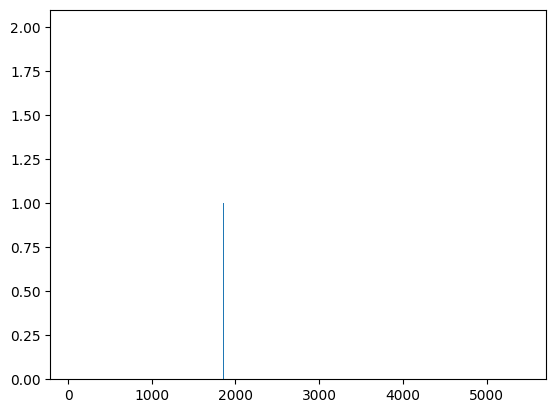

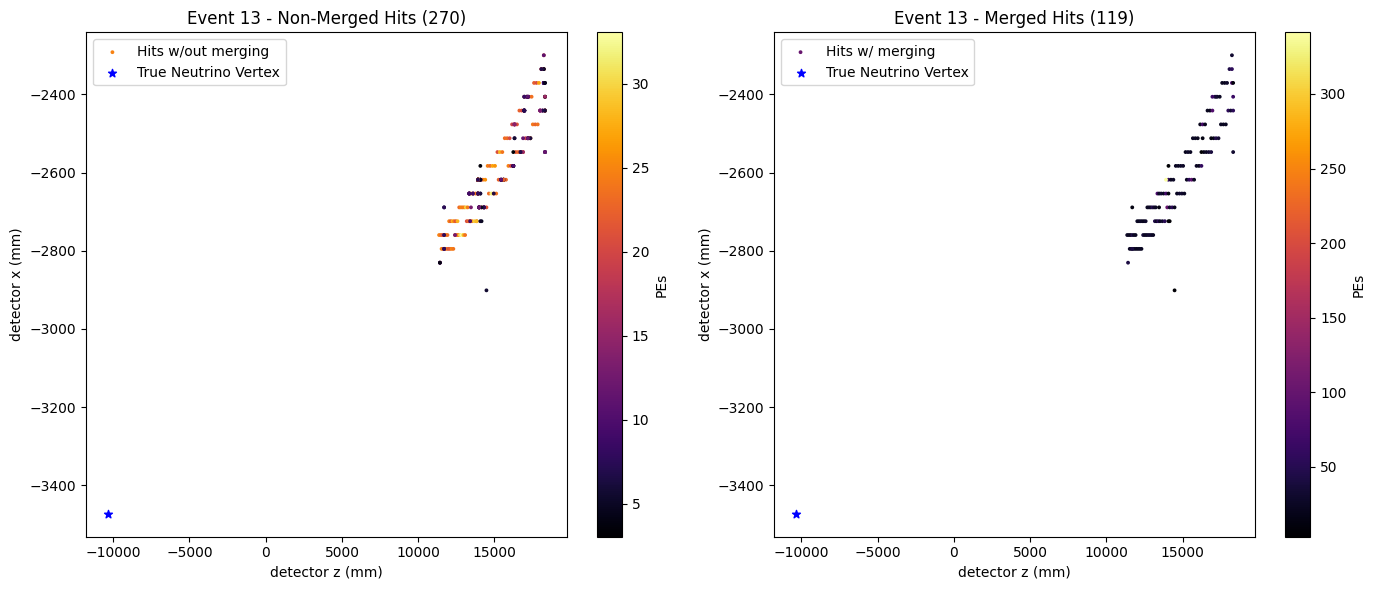

In [13]:
event_number_example = 13

# Reco hit data
merged_hit_xs = []
merged_hit_zs = []
merged_hit_PEs = []
merged_hit_Ts = []

original_hit_xs = []
original_hit_zs = []
original_hit_PEs = []
original_hit_Ts = []

original_hits_n = 0
merged_hits_n = 0
for hit in merged_hit_collection:
    if (hit[0] == event_number_example):
        merged_hits_n += 1
        merged_hit_xs.append(hit[2])
        merged_hit_zs.append(hit[4])
        merged_hit_Ts.append(hit[5])
        merged_hit_PEs.append(hit[6])
        
for hit in hit_array:
    if (hit[0] == event_number_example):
        original_hits_n += 1
        original_hit_xs.append(hit[2])
        original_hit_zs.append(hit[4])
        original_hit_Ts.append(hit[5])
        original_hit_PEs.append(hit[6])

event_neutrino = [vtx for vtx in neutrino_vertices if vtx[0] == event_number_example]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot reco hit
sc2 = ax2.scatter(merged_hit_zs, merged_hit_xs, s=3, c=merged_hit_PEs, cmap='inferno', label='Hits w/ merging')
ax2.scatter(event_neutrino[0][3], event_neutrino[0][1], s=35, c='blue', marker='*', label='True Neutrino Vertex')
ax2.set_xlabel("detector z (mm)")
ax2.set_ylabel("detector x (mm)")
ax2.set_title(f"Event {event_number_example} - Merged Hits ({merged_hits_n})")
ax2.legend()
fig.colorbar(sc2, ax=ax2, label='PEs')

# Plot truth hits
sc1 = ax1.scatter(original_hit_zs, original_hit_xs, s=3, c=original_hit_PEs, cmap='inferno', label='Hits w/out merging')
ax1.scatter(event_neutrino[0][3], event_neutrino[0][1], s=35, c='blue', marker='*', label='True Neutrino Vertex')
ax1.set_xlabel("detector z (mm)")
ax1.set_ylabel("detector x (mm)")
ax1.set_title(f"Event {event_number_example} - Non-Merged Hits ({original_hits_n})")
ax1.legend()
fig.colorbar(sc1, ax=ax1, label='PEs')


plt.tight_layout()
plt.show()


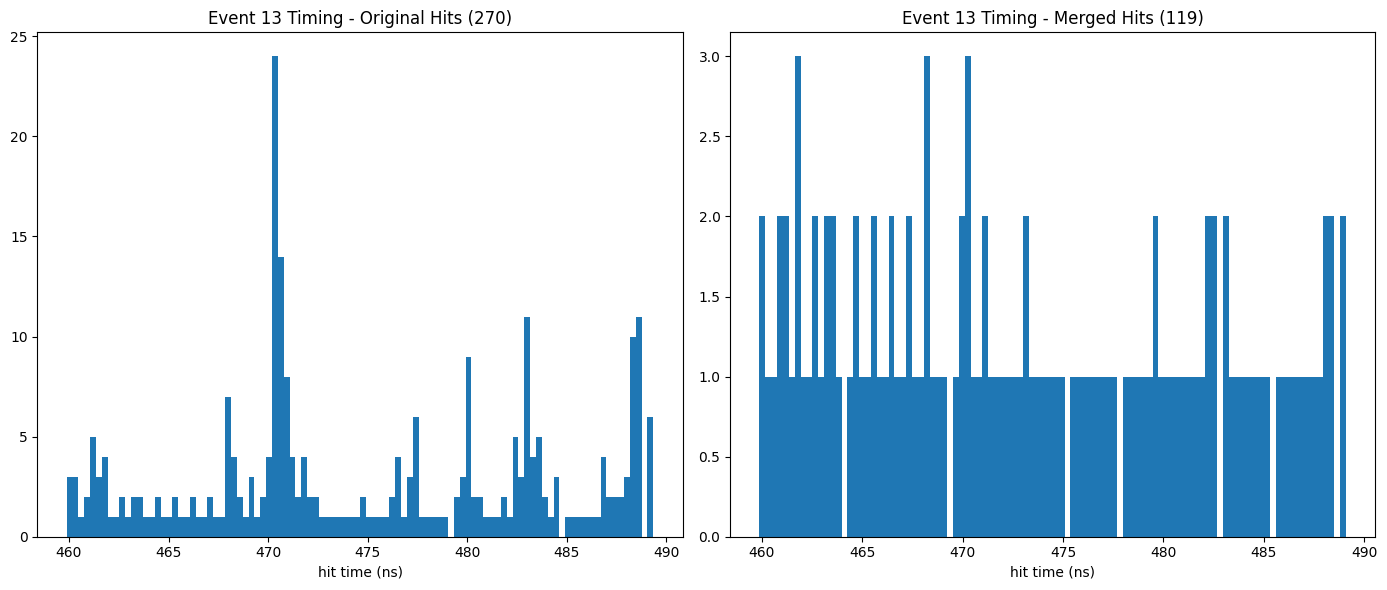

In [14]:
# Plot merged hit times
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sc2 = ax2.hist(merged_hit_Ts, bins=100)
ax2.set_xlabel("hit time (ns)")
ax2.set_title(f"Event {event_number_example} Timing - Merged Hits ({merged_hits_n})")

# Plot original hit times
sc1 = ax1.hist(original_hit_Ts, bins=100)
ax1.set_xlabel("hit time (ns)")
ax1.set_title(f"Event {event_number_example} Timing - Original Hits ({original_hits_n})")


plt.tight_layout()
plt.show()

In [125]:
#Let's see if we can do something rlly interesting - comparing to the dune-tms hit reco. 
import uproot

In [127]:
reco_file = uproot.open('/sdf/home/t/tanaka/MicroProdN4p1_NDComplex_FHC.tmsreco.full.0002459.TMSRECO.root')

In [128]:
reco_file.keys()

['Truth_Info;2',
 'Truth_Info;1',
 'Line_Candidates;2',
 'Line_Candidates;1',
 'Reco_Tree;2',
 'Reco_Tree;1',
 'Truth_Spill;1']

In [168]:
Truth_Tree = reco_file['Truth_Info']
Truth_Tree.keys()

['EventNo',
 'SpillNo',
 'RunNo',
 'IsCC',
 'Interaction',
 'TruthInfoIndex',
 'TruthInfoNSlices',
 'nPrimaryVertices',
 'HasPileup',
 'NeutrinoPDG',
 'NeutrinoP4',
 'NeutrinoX4',
 'nTrueParticles',
 'nTruePrimaryParticles',
 'nTrueForgottenParticles',
 'VertexID',
 'Parent',
 'TrackId',
 'PDG',
 'IsPrimary',
 'TrueVisibleEnergy',
 'TrueNHits',
 'TruePathLength',
 'TruePathLengthIgnoreY',
 'TruePathLengthInTMS',
 'TruePathLengthInTMSIgnoreY',
 'InteractionTMSFiducial',
 'InteractionTMSFirstTwoModules',
 'InteractionTMSThin',
 'InteractionLArFiducial',
 'TMSFiducialStart',
 'TMSFiducialTouch',
 'TMSFiducialEnd',
 'LArFiducialStart',
 'LArFiducialTouch',
 'LArFiducialEnd',
 'BirthMomentum',
 'BirthPosition',
 'DeathMomentum',
 'DeathPosition',
 'MomentumLArStart',
 'PositionLArStart',
 'MomentumLArEnd',
 'PositionLArEnd',
 'MomentumTMSStart',
 'PositionTMSStart',
 'MomentumTMSFirstTwoModulesEnd',
 'PositionTMSFirstTwoModulesEnd',
 'MomentumTMSThinEnd',
 'PositionTMSThinEnd',
 'MomentumTM

[False, False, False, True, True, False, ..., False, False, False, False, False]
81


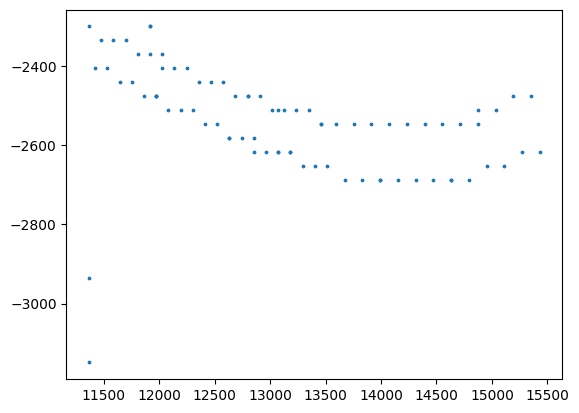

In [181]:
#haha I found one!
event_no = 3
tms_reco_x = [] #Truth_Tree['TrueRecoHitX'].arrays().TrueRecoHitX[event_no]
tms_reco_z = [] #Truth_Tree['TrueRecoHitZ'].arrays().TrueRecoHitZ[event_no]
tms_reco_PE = [] #Truth_Tree['TrueRecoHitPE'].arrays().TrueRecoHitPE[event_no]
tms_reco_T = [] #ruth_Tree['TrueRecoHitT'].arrays().TrueRecoHitT[event_no]
tms_reco_ped_sup = Truth_Tree['TrueRecoHitIsPedSupped'].arrays().TrueRecoHitIsPedSupped[event_no]
print(tms_reco_ped_sup)
n_real = 0
for i, state in enumerate(tms_reco_ped_sup):
    if not state:
        n_real += 1
        tms_reco_x.append(Truth_Tree['TrueRecoHitX'].arrays().TrueRecoHitX[event_no][i])
        tms_reco_z.append(Truth_Tree['TrueRecoHitZ'].arrays().TrueRecoHitZ[event_no][i])
        tms_reco_PE.append(Truth_Tree['TrueRecoHitPE'].arrays().TrueRecoHitPE[event_no][i])
        tms_reco_T.append(Truth_Tree['TrueRecoHitT'].arrays().TrueRecoHitT[event_no][i])
        

print(n_real)
n_reco_hits = n_real
plt.scatter(tms_reco_z, tms_reco_x, s =3)

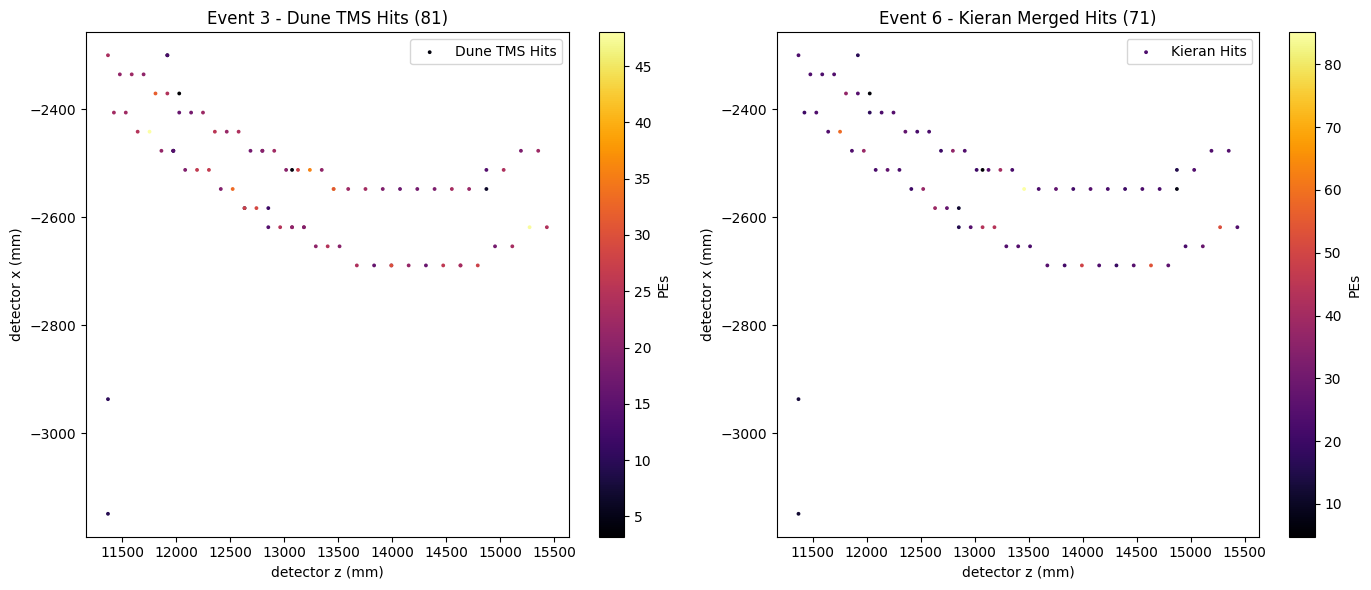

In [182]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot our detector reco
sc2 = ax2.scatter(merged_hit_zs, merged_hit_xs, s=3, c=merged_hit_PEs, cmap='inferno', label='Kieran Hits')
ax2.set_xlabel("detector z (mm)")
ax2.set_ylabel("detector x (mm)")
ax2.set_title(f"Event {event_number_example} - Kieran Merged Hits ({merged_hits_n})")
ax2.legend()
fig.colorbar(sc2, ax=ax2, label='PEs')

# Plot tms reco hits
sc1 = ax1.scatter(tms_reco_z, tms_reco_x, s=3, c=tms_reco_PE, cmap='inferno', label='Dune TMS Hits')
ax1.set_xlabel("detector z (mm)")
ax1.set_ylabel("detector x (mm)")
ax1.set_title(f"Event {event_no} - Dune TMS Hits ({n_reco_hits})")
ax1.legend()
fig.colorbar(sc1, ax=ax1, label='PEs')


plt.tight_layout()
plt.show()

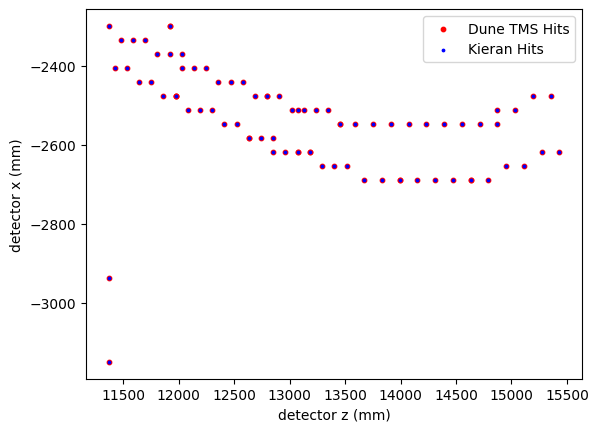

In [206]:
plt.scatter(tms_reco_z, tms_reco_x, s=10, c= 'red', label='Dune TMS Hits')
plt.scatter(merged_hit_zs, merged_hit_xs, s=3, c = 'blue' , label='Kieran Hits')
plt.xlabel("detector z (mm)")
plt.ylabel("detector x (mm)")
plt.legend()
plt.show()

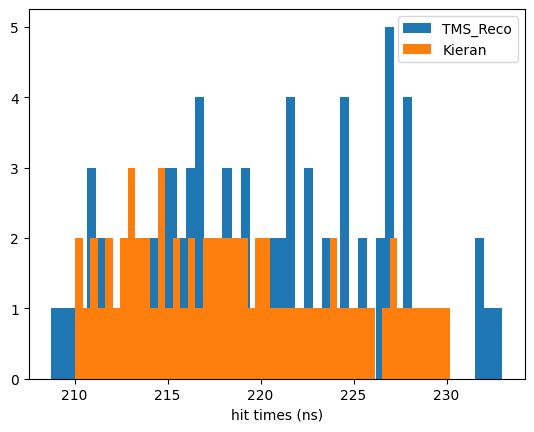

In [184]:
plt.hist(tms_reco_T, label = 'TMS_Reco', bins = 50)
plt.hist(merged_hit_Ts, label = 'Kieran', bins = 50)
plt.xlabel("hit times (ns)")
plt.legend()